In [3]:
from fastai.vision.all import *
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import umap

In [4]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_tiny_cqt".format(dest_path))
files = [str(x) for x in get_image_files(path)]

print("Found {} squeaks!".format(len(files)))
files[0]

Found 8224 squeaks!


'/home/jupyter/data/egyptian_fruit_bat_annotated_tiny_cqt/files210/121220010548932125.png'

In [8]:
def get_x(p):
    #returns a gs numpy array
    return np.array(Image.open(p))[:, :, 0]

def get_items(p):
    return get_image_files(p)

size = 100
bs =  8
dls = DataBlock(blocks = (ImageBlock, ImageBlock), 
                get_items = get_items, 
                get_x = get_x, 
                get_y = get_x,
                item_tfms = Resize((size, size), method = "squish"),
                splitter = RandomSplitter()).dataloaders(path, 
                                                         bs = bs)

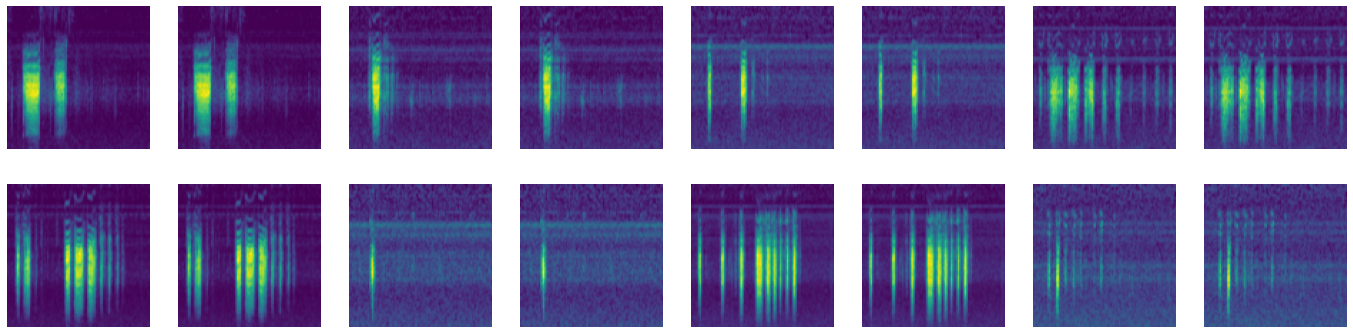

In [9]:
dls.show_batch()

In [10]:
def pos_enc2d_np(gs_im, out_c = 5, eta = 0.05):
    def constrain(x, a, b):
        if x > b: return b
        if x < a: return a
        else: return x

    def make_mask(shape, start, end):
        #returns a vertical mask:
        block_0 = np.zeros((shape[1], start))
        block_1 = np.ones((shape[1], end - start))
        block_2 = np.zeros((shape[1], constrain(shape[0] - end, 0, shape[0])))
        mask = np.block([block_0, block_1, block_2])
        
        if mask.shape != shape:
            return mask[:shape[1], :shape[1]]
        else: return mask

    window_widths = np.random.uniform((1/(out_c-2)) - eta, 
                                      (1/(out_c-2)) + eta, out_c)
    window_widths = np.round(window_widths*gs_im.shape[0]).astype(np.uint8)   
    
    window_starts = np.random.uniform((1/out_c) - eta, 
                                      (1/out_c) + eta, out_c)
    
    window_starts = np.array([sum(window_starts[0:i]) for i in range(out_c)])
    window_starts = np.round(window_starts*gs_im.shape[0]).astype(np.uint8)   
    new_ims = []
    
    for i in range(out_c):
        if i < out_c:
            temp_mask = make_mask(gs_im.shape, 
                                  start = window_starts[i], 
                                  end = window_starts[i] + window_widths[i])
        if i == out_c:
            #making sure the last mask gets the last of the image:
            temp_mask = make_mask(gs_im.shape, 
                                  start = int(gs_im.shape[0]*out_c), 
                                  end = gs_im.shape[0])

        new_ims.append(np.multiply(temp_mask, gs_im))
    return np.dstack(new_ims)   

def pos_enc2d_layer(tensor, out_c = 6, eta = 0.05):
    #adapting the pos_enc2d to act as a layer in the model:
    bs, channels, h, w = tensor.shape
    assert channels == 1, "Input should have one channel!"
    np_tensor = np.array(tensor.cpu()) #a little hacky! probably could be better!
    stack = [pos_enc2d_np(np_tensor[i,:, :, :].reshape(h, w), out_c, eta) for i in range(bs)]
    stack  = np.array(stack).reshape(bs, out_c, h, w)
    return torch.from_numpy(stack).type(torch.cuda.FloatTensor)

a = torch.from_numpy(np.random.rand(1, 1, 100, 100))
print(a.shape)
print(pos_enc2d_layer(a).shape)

torch.Size([1, 1, 100, 100])
torch.Size([1, 6, 100, 100])


In [11]:
class VAE(Module):
    #a pretty complicated identity map! 
    
    def __init__(self):
        super().__init__()
        
        self.size = size
        self.enc_size = 10
        self.in_c = 5
        self.conv_block_1_32 = nn.Sequential(*[
                            nn.Conv2d(kernel_size = (5, 5),
                                       in_channels = self.in_c, 
                                       out_channels = 4, 
                                       stride = (1, 1), 
                                       padding = (1, 1), 
                                       bias = False), 
                             nn.BatchNorm2d(4, 
                                            momentum = 0.1, 
                                            affine = True, 
                                            track_running_stats = True),
                             nn.Conv2d(in_channels = 4, 
                                       out_channels = 32,
                                       kernel_size = (3, 3), 
                                       stride = (1, 1), 
                                       padding = (1, 1), 
                                       bias = False),
                             nn.ReLU(inplace = True),
                             nn.BatchNorm2d(32, 
                                            momentum = 0.1, 
                                            affine = True, 
                                            track_running_stats = True)
                            ])
        
        self.conv_block_32_32 = nn.Sequential(*[
                            nn.Conv2d(kernel_size = (5, 5),
                                       in_channels = 32, 
                                       out_channels = 64, 
                                       stride = (1, 1), 
                                       padding = (1, 1), 
                                       bias = False), 
                             nn.ReLU(inplace = True),
                             nn.Conv2d(in_channels = 64, 
                                       out_channels = 32,
                                       kernel_size = (3, 3), 
                                       stride = (1, 1), 
                                       padding = (1, 1), 
                                       bias = False),
                             nn.ReLU(inplace = True),
                             nn.BatchNorm2d(32, 
                                            momentum = 0.1, 
                                            affine = True, 
                                            track_running_stats = True)
                            ])
        
        self.encoder = nn.Sequential(*[
                         nn.Conv2d(in_channels = 32, 
                                   out_channels = 32, 
                                   kernel_size = (3, 3), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                         nn.Conv2d(in_channels = 32, 
                                   out_channels = 8, 
                                   kernel_size = (3, 3), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                         nn.Conv2d(in_channels = 8, 
                                   out_channels = 1, 
                                   kernel_size = (3, 3), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                         nn.ReLU(inplace = True),
                         nn.AdaptiveMaxPool2d(output_size = (self.enc_size, self.enc_size))
                        ])
        
        self.decoder = nn.Sequential(*[
                        nn.Conv2d(in_channels = 1, 
                               out_channels = 8, 
                               kernel_size = (3, 3), 
                               stride = (1, 1), 
                               padding = (1, 1), 
                               bias = False),
                        nn.Upsample(scale_factor = 5, 
                                    mode = "bilinear", 
                                    align_corners = True),
                        nn.Conv2d(in_channels = 8,     
                                   out_channels = 8, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Upsample(scale_factor = 5, 
                                    mode = "bilinear", 
                                    align_corners = True),
                        nn.Conv2d(in_channels = 8,     
                                   out_channels = 8, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Upsample(scale_factor = 3, 
                                    mode = "bilinear", 
                                    align_corners = True),
                        nn.BatchNorm2d(8, 
                                    momentum = 0.1, 
                                    affine = True, 
                                    track_running_stats = True),
                        nn.Conv2d(in_channels = 8,     
                                   out_channels = 16, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Conv2d(in_channels = 16,     
                                   out_channels = 16, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Conv2d(in_channels = 16,     
                                   out_channels = 16, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Upsample(scale_factor = 2, 
                                    mode = "bilinear", 
                                    align_corners = True),
                        nn.Conv2d(in_channels = 16,     
                                   out_channels = 8, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.Conv2d(in_channels = 8,     
                                   out_channels = 1, 
                                   kernel_size = (10, 10), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias = False),
                        nn.ReLU(inplace = True),
                        nn.AdaptiveMaxPool2d(output_size = (self.size, self.size))
                        ])
        
    def forward(self, x):
        x = pos_enc2d_layer(x, out_c = self.in_c)
        x = self.conv_block_1_32(x)
        x = self.conv_block_32_32(x)
        x = self.encoder(x)
        self.encoding_layer_outputs = x #store activations
        x = self.decoder(x)
        return x
    
    
def vae_loss(output, target):
        bs, c, w, h = output.shape
        o, t = output.detach().numpy(), target.detach().numpy()
        o, t = o.reshape(bs, w, h), t.reshape(bs, w, h)
        
        bce = F.binary_cross_entropy(torch.sigmoid(output), 
                                     torch.sigmoid(target), 
                                     reduction = 'sum')
        kld_loss = nn.KLDivLoss(reduction = 'sum')
        kld = kld_loss(torch.sigmoid(output), 
                       torch.sigmoid(target))
        mse_loss = nn.MSELoss(reduction = 'sum')
        mse = mse_loss(torch.sigmoid(output), 
                       torch.sigmoid(target))
        
        return bce 

In [12]:
#just want to create a callback to see how the model is doing at predicting a single image:
from PIL import Image
class VAE_Output_Callback(Callback):
    def __init__(self, learner):
        self.learner = learner
        self.model = self.learner.model
        self.test_im = np.array(Image.open(files[10]).reshape(size, size))[:, :, 0]
        self.test_im = self.test_im.astype("float32")
        
        self.torch_test_im = torch.from_numpy(self.test_im.reshape(1, 1, size, size))
        
        
    def after_epoch(self):
        plt.subplot(131)
        plt.imshow(self.test_im)
        plt.axis("off")
        plt.subplot(133)
        pred_im = self.model.forward(self.torch_test_im).cpu().detach().view(size, size)
        plt.imshow(pred_im)
        plt.axis("off")
        plt.subplot(132)
        enc_im = self.model.encoding_layer_outputs.cpu().detach().numpy()
        plt.imshow(enc_im.reshape(self.model.enc_size, self.model.enc_size))
        plt.axis("off")
        plt.show() 

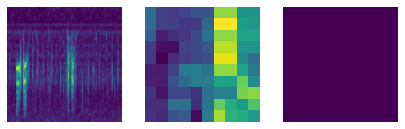

VAE (Input shape: ['8 x 1 x 100 x 100'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 4 x 98 x 98      500        True      
________________________________________________________________
BatchNorm2d          8 x 4 x 98 x 98      8          True      
________________________________________________________________
Conv2d               8 x 32 x 98 x 98     1,152      True      
________________________________________________________________
ReLU                 8 x 32 x 98 x 98     0          False     
________________________________________________________________
BatchNorm2d          8 x 32 x 98 x 98     64         True      
________________________________________________________________
Conv2d               8 x 64 x 96 x 96     51,200     True      
________________________________________________________________
ReLU                 8 x 64 x 96 x 96     0          False     
_________________________________________________________

In [13]:
np.random.seed(42)
learner = Learner(dls, 
                  VAE(), 
                  loss_func = nn.MSELoss(reduction = 'sum'))

cb =  VAE_Output_Callback(learner)
learner = learner.add_cb(cb)

learner.summary()

epoch,train_loss,valid_loss,time
0,1007.826294,1095.971802,20:48
1,949.549316,1057.958496,20:00
2,834.322998,761.126770,19:54
3,806.568909,839.898193,19:53
4,726.688416,689.151917,19:50


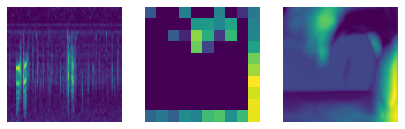

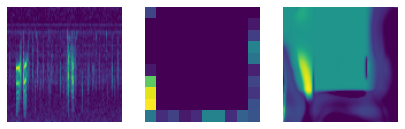

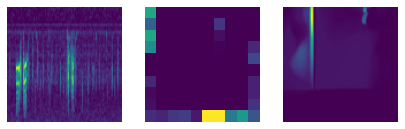

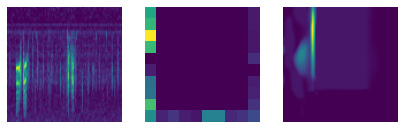

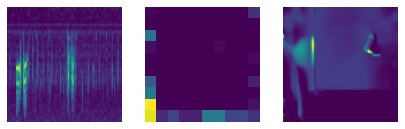

In [14]:
learner.fit_one_cycle(5)

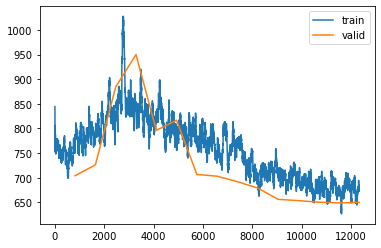

In [23]:
learner.save("efb_vae")
learner.recorder.plot_loss()

In [24]:
model = learner.model.eval()
dls_iter = next(iter(dls))

in_ims, out_ims = next(iter(dls_iter))
preds = model(in_ims)
enc_layers = model.encoding_layer_outputs.cpu().detach().numpy()


In [ ]:
for _ in range(10):
    plt.figure(figsize=(10, 10))
    i = np.random.randint(0, bs)
    plt.subplot(133)
    plt.imshow(preds.cpu().detach().numpy()[i].reshape(size, size))
    plt.axis("off")
    plt.subplot(131)
    plt.imshow(in_ims.cpu().detach().numpy()[i].reshape(size, size))
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(enc_layers[i].reshape(10, 10))
    plt.axis("off")
    plt.show()

epoch,train_loss,valid_loss,time
0,781.747070,704.040161,19:53
1,792.119080,726.039795,19:52
2,823.467773,884.230469,19:52
3,844.316650,950.091797,19:53
4,817.537170,796.133545,19:54
5,769.492737,816.720520,19:53
6,780.125366,706.651855,19:53
7,746.440308,703.010254,19:54
8,761.369934,691.834717,19:54
9,706.721863,678.931702,19:54


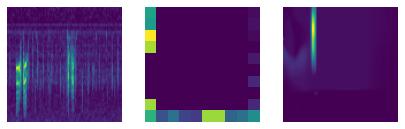

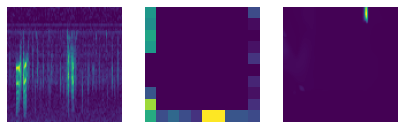

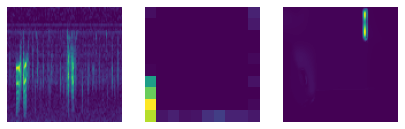

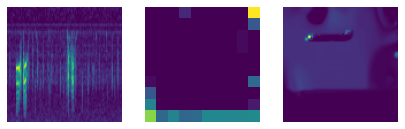

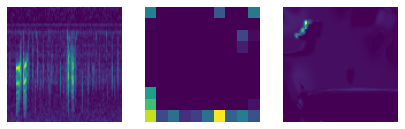

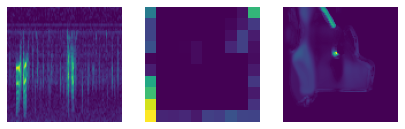

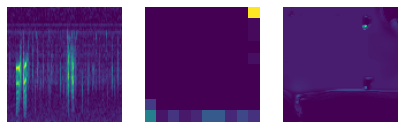

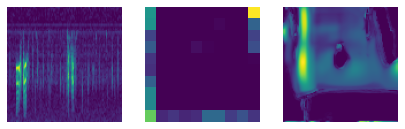

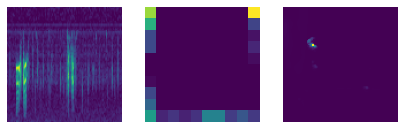

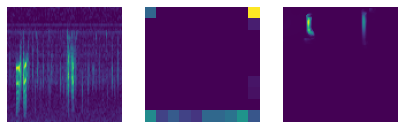

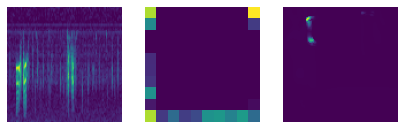

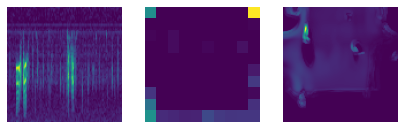

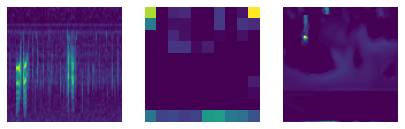

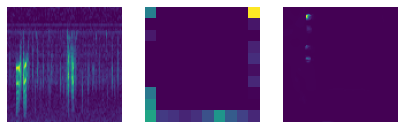

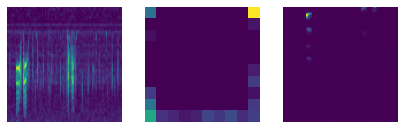

Path('models/efb_vae.pth')

In [20]:
learner.fit_one_cycle(15)
learner.save("efb_vae")